In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from utils.EnvironmentBasics import Environment, Action, State, ActionOrAid
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy
from tqdm import tqdm
from typing import *
import cv2

In [10]:
class MovingRewardState(State):
    reward_i = 0
    count = 0
    interval_change_reward = 1000_000
    reward_changed = False
    def __init__(self, name: str, rewards: Union[np.ndarray, List[float]], is_terminal: bool = False, representation: Any = None) -> None:
        super().__init__(name, rewards, is_terminal, representation)
        self.n_rewards = len(rewards)

    def getReward(self) -> float:
        if self.is_terminal:
            MovingRewardState.updateRewardi()
        return self.rewards[self.__class__.reward_i % self.n_rewards]
    
    @classmethod
    def updateRewardi(cls):
        if cls.count % cls.interval_change_reward == 0:
            cls.reward_i += 1
            cls.reward_changed = True
        cls.count += 1

class GridWorldMovingReward(GridWorld):
    def __init__(self, world_size: int, win_states: List[Tuple[int, int]] = None, fail_states: List[Tuple[int, int]] = None):
        """ Rewrite GridWorld class, make state rewards more random

        :param world_size: size of the world
        """
        state_space = []
        n_win_states = len(win_states)
        i = 0
        for row in range(world_size):
            for col in range(world_size):
                if (row, col) in win_states:
                    is_terminal = True
                    rewards = [0.2] * n_win_states
                    rewards[i] = 1
                    i += 1
                    representation = "W"
                elif (row, col) in fail_states:
                    is_terminal = True
                    rewards = [-2]
                    representation = "F"
                else:
                    is_terminal = False
                    rewards = [0]
                    representation = " "
                state_space.append(MovingRewardState(f"({row},{col})", rewards, is_terminal, representation=representation))

        action_space = [Action("left"), Action("right"), Action("down"), Action("up")]
        super().__init__(world_size, win_states + fail_states, state_space, action_space)
        self.path = [self.current_sid]

    def render(self, agent:Agent=None, figsize:Tuple[int, int]=None):
        """ Render the environment, override method in Environment class
        1. draw the states as grids
        2. no need to draw transitions, because they are obvious in the grid world
        3. highlight current state
        4. highlight start state
        5. highlight terminal states
        """
        # if figsize is None:
        #     figsize = (5, 5)
        # plt.figure(figsize=figsize)

        fig = Figure(figsize=figsize)
        canvas = FigureCanvas(fig)
        ax = fig.gca()

        plt.xlim(-1, self.world_size)
        plt.ylim(-1, self.world_size)
        color = agent.state_value if agent is not None else [state.is_terminal for state in self.states]
        ax.scatter(self.grid_colid, self.grid_rowid, c=color, marker="s", s=1000, alpha=0.75, cmap="winter", vmin=0, vmax=1)
        path = [self.stateIdToCoord(sid) for sid in self.path]
        ax.plot([p[0] for p in path], [p[1] for p in path], c="#000000", linewidth=2)
        for gi in range(self.n_grids):
            label = f"{agent.state_value[gi] if agent is not None else self.states[gi].is_terminal:.2f}"
            ax.annotate(label, (self.grid_colid[gi], self.grid_rowid[gi]), textcoords="offset points", xytext=(2, -2), ha="center")

        self.highlightTerminalStates(ax)
        if agent is not None:
            for sid in range(self.n_states):
                if not self.isTerminalState(sid):
                    for action in self.getValidActionIds(sid):
                        row, col = self.stateIdToCoord(sid)
                        self.drawArrow(ax, col, row, action, agent.policy[sid, action])

        canvas.draw()       # draw the canvas, cache the renderer
        return np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))

    def step(self, action: ActionOrAid) -> Tuple[Union[int, State], float, bool]:
        """
        Step to the next state according to the current state and the action taken
        :param action: action id or action
        :return: next state id, reward, is_terminal
        """
        assert self.isValidAction(self.current_sid, action), f"Invalid action {action} in state {self.current_sid}"
        # According to the current state and the action taken, choose one of the next states based on the probabilities
        next_sid = np.random.choice(self.n_states, p=self.transitions[self.current_sid, action, :])
        next_state = self.sid_to_state[next_sid]
        reward = next_state.getReward()
        self.current_sid = next_sid
        self.path.append(next_sid)
        return next_sid, reward, next_state.is_terminal

    def highlightTerminalStates(self, ax):
        """ Highlight terminal states """
        for row in range(self.world_size):
            for col in range(self.world_size):
                if self.sid_to_state[self.coordToStateId(row, col)].representation == "W":
                    ax.scatter(col, row, c="green", marker="s", s=700)
                elif self.sid_to_state[self.coordToStateId(row, col)].representation == "F":
                    ax.scatter(col, row, c="red", marker="s", s=700)

    
    def drawArrow(self, ax, x: int, y: int, action: Union[Action, int], length: float = 1):
        """ Draw an arrow from point x, y, direction code: {0: "left", 1: "right", 2: "down", 3: "up"} """
        if not isinstance(action, Action):
            action = self.aid_to_action[action]
        dx, dy = 0, 0
        if action.name == "left":
            dx = np.clip(-1 * length, 0, 0.9)
        elif action.name == "right":
            dx = np.clip(1 * length, 0, 0.9)
        elif action.name == "down":
            dy = np.clip(-1 * length, 0, 0.9)
        elif action.name == "up":
            dy = np.clip(1 * length, 0, 0.9)

        ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, length_includes_head=True)


    def reset(self, start_state_id: int=-1) -> int:
        """ Reset the environment to the start state
        If start_state_id is not specified or set to -1, choose a random start state

        :param start_state_id: the id of the start state, defaults to -1
        :return: the start state id
        """
        if start_state_id == -1:
            self.start_sid = np.random.randint(self.n_states)
        else:
            self.start_sid = start_state_id
        self.current_sid = self.start_sid
        self.path = [self.current_sid]
        return self.start_sid

# Sarsa: On-Policy TD Control
当谈到Control的时候，就是指我们在循环的过程中，action-value和policy不断地交替更新，最终实现收敛，也就是Generalized Policy Iteration (GPI)。<p>
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',a') - Q(s,a) \right]$$
书里原公式为：
$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right]$$
这个公式就是TD(0)的公式换成了action-value的更新。<p>


$Q(S_t,A_t)$是当前状态和动作的action-value，我们要bootstrap，因此就是要用旧的来估计新的，注意等式右边除了$R_{t+1}$没一个东西是新的<p>
$R_{t+1} + \gamma Q(S_{t+1},A_{t+1})$是我们根据实际获得的reward和下一个状态的旧action-value算出来的新的action-value估计值。<p>
那么$R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)$就是我们的error，是新估计值和旧估计值的差。<p>
然后这个差乘上step-size，就是我们要更新的量。最后把这个更新的量加到当前action-value上，就更新了action-value<p>

<mark>注意！！！一定要在terminal state时设置terminal state的action-value因为在terminal state时你拿不到下一个action-value，因此我之前把它忽略掉了，导致action-value在碰到terminal state时无法得到来自terminal state的reward(其实是-1的penalty)，最终导致policy不知道去躲避陷阱terminal state。</mark><

Sarsa:  95%|█████████▌| 9500/10000 [01:24<00:04, 112.73it/s]


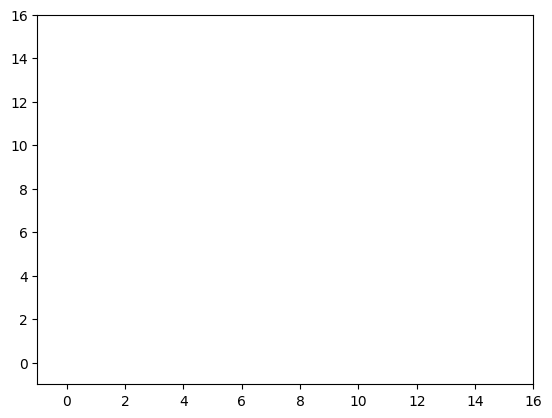

In [11]:
def Sarsa(grid_world: GridWorldMovingReward):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    for sid in grid_world.getTerminalStateIds():
        agent.state_value[sid] = grid_world.states[sid].getReward()
    gamma = 0.9
    step_size = 0.2

    for it in tqdm(range(10000), desc="Sarsa"):
        # Generate episode
        is_terminal = True
        while is_terminal:
            grid_world.reset(0)  # reset with a random start state
            is_terminal = grid_world.isTerminalState(grid_world.start_sid)

        # iterate over all state action pairs to reset policy
        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        old_sid = grid_world.start_sid
        old_aid = agent.takeAction(old_sid, epsilon=0.4)

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            new_sid, r, is_terminal = grid_world.step(old_aid)

            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if is_terminal:
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, old_aid] += step_size * (r - agent.action_value[old_sid, old_aid])
                # agent.action_value[old_sid, old_aid] = 0
                break
            new_aid = agent.takeAction(new_sid, epsilon=0.4)

            agent.action_value[old_sid, old_aid] += step_size * (r + gamma * agent.action_value[new_sid, new_aid] - agent.action_value[old_sid, old_aid])

            # agent.policy[old_sid, old_aid] = agent.state_value[old_sid]
            # # agent.policy[old_sid, old] = agent.action_value[old_sid]
            # av_sum = np.sum(agent.action_value[old_sid])
            # if av_sum != 0:
            #     agent.policy[old_sid] /= av_sum
            # else:
            #     agent.policy[old_sid] = 0.25
            # best_action_ids = agent.getBestActions(old_sid)
            # agent.policy[old_sid] = 0
            # agent.policy[old_sid, best_action_ids] = 1
            # agent.policy[old_sid] /= np.sum(agent.policy[old_sid])

            old_aid = new_aid
            old_sid = new_sid

        if MovingRewardState.reward_changed:
            for sid in grid_world.getTerminalStateIds():
                agent.state_value[sid] = grid_world.states[sid].getReward()
            MovingRewardState.reward_changed = False

        if it % 100 == 0:
            agent.policy.normalize()
            img = grid_world.render(agent, figsize=(10, 10))
            cv2.imshow("img", img)
            k = cv2.waitKey(1)
            if k == ord("q"):
                break
    cv2.destroyAllWindows()

Sarsa(GridWorldMovingReward(world_size=16, 
                        win_states=[(10, 2), (4, 10), (14, 14)], 
                        fail_states=[(4, 4), (6, 6), (10, 10), (12, 12)]
                        )
    )